Duplicates: 1186
After dedup: 213764
Age 0 count: 3912
After age filter: 209852
Survival distribution:
 survived
1    206365
0      3487
Name: count, dtype: int64

=== Q4: Alcohol Effect ===
Starting causal effect estimation...
Treatment variable: alcohol
Outcome variable: survived
Number of confounders: 17
Dropping missing values...
Remaining samples after dropping NA: 209851
Creating causal model...
Identifying causal effect...
Estimating effect using PSM...
alcohol ATE: 0.0060
Running refutation tests...
1. Placebo treatment refutation:
Refute: Use a Placebo Treatment
Estimated effect:0.006018556023083045
New effect:0.00039408913943702906
p value:0.96

2. Random common cause refutation:
Refute: Add a random common cause
Estimated effect:0.006018556023083045
New effect:0.006018556023083047
p value:1.0

Computing naive difference in means...
Naive diff-in-means: 0.0038
Causal effect estimation complete.

=== Q5: Hospital Effect ===
Hospital survival difference std: 0.05340669455562482

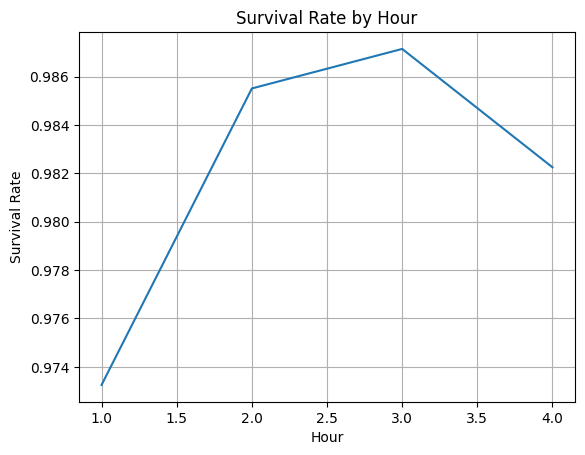

In [1]:
import os
import re

import numpy as np  # numpy documentation: https://numpy.org/doc/
import pandas as pd  # pandas documentation: https://pandas.pydata.org/docs/
import matplotlib.pyplot as plt  # matplotlib documentation: https://matplotlib.org/stable/api/pyplot_api.html

from sklearn.ensemble import RandomForestClassifier  # scikit-learn: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
from sklearn.linear_model import LogisticRegression  # scikit-learn: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
from sklearn.preprocessing import StandardScaler
from dowhy import CausalModel  # dowhy: https://microsoft.github.io/dowhy/


def load_data(path: str) -> pd.DataFrame:
    """Load raw Excel data."""
    return pd.read_excel(path)


def clean_data(df: pd.DataFrame) -> pd.DataFrame:
    """
    Perform data cleaning:
    1. Remove duplicates.
    2. Filter valid ages.
    3. Create binary survival label.
    4. Extract month and hour correctly.
    5. Encode sex.
    6. Drop unneeded columns.
    """
    df = df.copy()
    # 1. Duplicates
    print(f"Duplicates: {df.duplicated().sum()}")
    df = df.drop_duplicates()
    print(f"After dedup: {df.shape[0]}")
    
    # 2. Age validity
    # Convert to numeric and filter invalid ages
    df['อายุ'] = pd.to_numeric(df['อายุ'], errors='coerce')
    print(f"Age 0 count: {(df['อายุ'] == 0).sum()}")
    df = df[df['อายุ'] > 0].dropna(subset=['อายุ'])
    print(f"After age filter: {df.shape[0]}")
    # Define bins and their midpoints
    age_bins = [0, 15, 25, 65, 200]
    bin_midpoints = {
        pd.Interval(0, 15, closed='left'): 7.5, 
        pd.Interval(15, 25, closed='left'): 20,
        pd.Interval(25, 65, closed='left'): 45,
        pd.Interval(65, 200, closed='left'): 80
    }
    # Bin ages and map to midpoints
    binned = pd.cut(df['อายุ'], bins=age_bins, right=False)
    df['อายุ'] = binned.map(bin_midpoints)
    
    # 3. Survival label
    df['survived'] = (df['ผลการรักษา'] == 'ทุเลา/หาย').astype(int)
    print("Survival distribution:\n", df['survived'].value_counts())
    df = df.drop(columns=['ผลการรักษา'])
    
    # 4. Date/Time processing
    df = df.rename(columns={'วันที่เกิดเหตุ': 'day_of_month'})
    df = df[df['day_of_month'].between(1, 31)]
    # # Map month for New Year period: days 29-31 -> Dec(12), days 1-4 -> Jan(1)
    # df['month'] = df['day_of_month'].apply(lambda x: 12 if x >= 29 else (1 if x <= 4 else np.nan))
    # df = df.dropna(subset=['month'])
    # df['month'] = df['month'].astype(int)
    
    def extract_hour(s):
        if pd.isna(s) or 'ไม่ทราบ' in str(s):
            return np.nan
        cleaned = re.sub(r'[^0-9:]', '', str(s))
        if cleaned.startswith('24:'):
            cleaned = '00:' + cleaned[3:]
        try:
            hour = int(cleaned.split(':')[0])
            # Map hours to quarters (0-6, 6-12, 12-18, 18-24)
            if 0 <= hour < 6:
                return 1  # First quarter (midnight to 6am)
            elif 6 <= hour < 12:
                return 2  # Second quarter (6am to noon)
            elif 12 <= hour < 18:
                return 3  # Third quarter (noon to 6pm)
            else:
                return 4  # Fourth quarter (6pm to midnight)
        except ValueError:
            return np.nan
    df['hour'] = df['เวลาเกิดเหตุ'].apply(extract_hour)
    df = df.drop(columns=['เวลาเกิดเหตุ'])
    # 5. Gender encoding
    df['sex'] = df['เพศ'].map({'ชาย': 1, 'หญิง': 0})
    df = df.drop(columns=['เพศ'])
    
    # 6. Drop irrelevant columns
    df = df.drop(columns=['จังหวัด', 'ชื่อโรงพยาบาลที่รับผู้บาดเจ็บ', 'ชื่อเทศกาล'], errors='ignore')
    return df


def feature_importance_rf(df: pd.DataFrame):
    """Compute and display top-5 feature importances via Random Forest."""
    feats = ['อายุ', 'sex', 'day_of_month', 
            #  'month', 
             'hour',
             'ถนนที่เกิดเหตุ', 'สถานะ', 'รถผู้บาดเจ็บ',
             'รถคู่กรณี', 'มาตรการ', 'การดื่มสุรา']
    sub = df[feats + ['survived']].dropna(subset=['hour'])
    sub = pd.get_dummies(sub, columns=[
        'ถนนที่เกิดเหตุ', 'สถานะ', 'รถผู้บาดเจ็บ',
        'รถคู่กรณี', 'มาตรการ', 'การดื่มสุรา'
    ], drop_first=True)
    X = sub.drop(columns=['survived'])
    y = sub['survived']
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X, y)
    imp = pd.Series(model.feature_importances_, index=X.columns)
    print("Top 20 factors affecting survivability:\n", imp.sort_values(ascending=False).head(20))


def estimate_causal_effect(df: pd.DataFrame, treatment: str, outcome: str, confounders: list):
    """
    Estimate ATE with DoWhy (PSM) and run two refutation tests.
    """
    print("Starting causal effect estimation...")
    print(f"Treatment variable: {treatment}")
    print(f"Outcome variable: {outcome}")
    print(f"Number of confounders: {len(confounders)}")
    
    print("Dropping missing values...")
    data = df.dropna(subset=[treatment, outcome] + confounders)
    print(f"Remaining samples after dropping NA: {len(data)}")
    
    print("Creating causal model...")
    model = CausalModel(
        data=data,
        treatment=treatment,
        outcome=outcome,
        common_causes=confounders
    )
    
    print("Identifying causal effect...")
    estimand = model.identify_effect()
    
    print("Estimating effect using PSM...")
    est = model.estimate_effect(estimand, method_name="backdoor.propensity_score_matching")
    print(f"{treatment} ATE: {est.value:.4f}")
    
    print("Running refutation tests...")
    print("1. Placebo treatment refutation:")
    print(model.refute_estimate(estimand, est, method_name="placebo_treatment_refuter"))
    print("2. Random common cause refutation:")
    print(model.refute_estimate(estimand, est, method_name="random_common_cause"))
    
    print("Computing naive difference in means...")
    naive = data[data[treatment] == 1][outcome].mean() - data[data[treatment] == 0][outcome].mean()
    print(f"Naive diff-in-means: {naive:.4f}")
    print("Causal effect estimation complete.")


def hospital_effect(df: pd.DataFrame):
    """Assess hospital-level deviations from expected survival."""
    feats = ['อายุ', 'sex', 'ถนนที่เกิดเหตุ', 'สถานะ',
             'รถผู้บาดเจ็บ', 'รถคู่กรณี', 'มาตรการ', 'การดื่มสุรา']
    sub = df[feats + ['survived', 'รหัส รพ.']].dropna()
    sub_enc = pd.get_dummies(sub, columns=feats, drop_first=True)
    X = sub_enc.drop(columns=['survived', 'รหัส รพ.'])
    y = sub_enc['survived']
    X_scaled = StandardScaler().fit_transform(X)
    log = LogisticRegression(max_iter=5000, solver='liblinear').fit(X_scaled, y)
    sub['expected'] = log.predict_proba(X_scaled)[:, 1]
    rates = sub.groupby('รหัส รพ.').agg(
        observed=('survived', 'mean'),
        expected=('expected', 'mean')
    )
    rates['difference'] = rates['observed'] - rates['expected']
    print("Hospital survival difference std:", rates['difference'].std())


def plot_hourly_survival(df: pd.DataFrame):
    """Plot survival rate by hour of day."""
    hr = (
        df[df['hour'].notnull()]
        .assign(hour=lambda x: x['hour'].astype(int))
        .groupby('hour')['survived']
        .mean()
    )
    hr.plot(title='Survival Rate by Hour', xlabel='Hour', ylabel='Survival Rate')
    plt.grid(True)
    plt.show()

def run_q1(df):
    """Run analysis for Q1: Feature Importances"""
    print("\n=== Q1: Feature Importances ===")
    feature_importance_rf(df)

def run_q2(df):
    """Run analysis for Q2: Helmet Effect"""
    print("\n=== Q2: Helmet Effect ===")
    df_mc = df[df['รถผู้บาดเจ็บ'] == 'จักรยานยนต์'].copy()
    df_mc = df_mc[df_mc['มาตรการ'].notna()]
    df_mc['helmet'] = (df_mc['มาตรการ'] == 'ใส่หมวก').astype(int)
    df_mc_enc = pd.get_dummies(df_mc, columns=['ถนนที่เกิดเหตุ','การดื่มสุรา'], drop_first=True)
    conf = ['อายุ','sex'] + [c for c in df_mc_enc.columns if c.startswith(('ถนนที่เกิดเหตุ_','การดื่มสุรา_'))]
    estimate_causal_effect(df_mc_enc, 'helmet', 'survived', conf)

def run_q3(df):
    """Run analysis for Q3: Seatbelt Effect"""
    print("\n=== Q3: Seatbelt Effect ===")
    car_types = ['รถเก๋ง/แท็กซี่', 'ปิคอัพ', 'รถตู้']
    df_car = df[df['รถผู้บาดเจ็บ'].isin(car_types)].copy()
    df_car = df_car[df_car['มาตรการ'].notna()]
    df_car['seatbelt'] = (df_car['มาตรการ'] == 'เข็มขัด').astype(int)
    df_car_enc = pd.get_dummies(df_car, columns=['ถนนที่เกิดเหตุ','การดื่มสุรา'], drop_first=True)
    conf_car = ['อายุ','sex'] + [c for c in df_car_enc.columns if c.startswith(('ถนนที่เกิดเหตุ_','การดื่มสุรา_'))]
    estimate_causal_effect(df_car_enc, 'seatbelt', 'survived', conf_car)

def run_q4(df):
    """Run analysis for Q4: Alcohol Effect"""
    print("\n=== Q4: Alcohol Effect ===")
    df_al = df[df['การดื่มสุรา'].notna()].copy()
    df_al['alcohol'] = (df_al['การดื่มสุรา'] == 'ดื่ม').astype(int)
    df_al_enc = pd.get_dummies(df_al, columns=['ถนนที่เกิดเหตุ','รถผู้บาดเจ็บ'], drop_first=True)
    conf_al = ['อายุ','sex'] + [c for c in df_al_enc.columns if c.startswith(('ถนนที่เกิดเหตุ_','รถผู้บาดเจ็บ_'))]
    estimate_causal_effect(df_al_enc, 'alcohol', 'survived', conf_al)

def run_q5(df):
    """Run analysis for Q5: Hospital Effect"""
    print("\n=== Q5: Hospital Effect ===")
    hospital_effect(df)

def run_q6(df):
    """Run analysis for Q6: Hourly Survival"""
    print("\n=== Q6: Hourly Survival ===")
    plot_hourly_survival(df)

def main():
    repo = os.path.dirname(os.getcwd())
    path = os.path.join(repo, 'final-project', 'data', 'raw.xlsx')
    df = load_data(path)
    df = clean_data(df)

    run_q1(df)
    run_q2(df)
    run_q3(df)
    run_q4(df)
    run_q5(df)
    run_q6(df)

if __name__ == '__main__':
    main()
